# Project Part 2: Benchmark and Optimization

In this milestone you will provide a report which includes the results of your benchmark and optimization.  Your report will include a performance benchmark on a single core and then a description of what you did to speed up the code and a graph of how much improvement you made over the benchmark.  Your final report should include the following:

- Project Title
- Motivating Image
- Abstract
- Methodology
- Timing Results
- Concluding Discussion and Future Work
- References



To help you out your instructor has provided the following template


# Part 2 - Parallel Execution and Query Optimization in PostgreSQL

_Amaan Thasin_

![PostgreSQL Logo](https://www.postgresql.org/media/img/about/press/elephant.png)

Image from: [PostgreSQL.org](https://www.postgresql.org/about/press/)


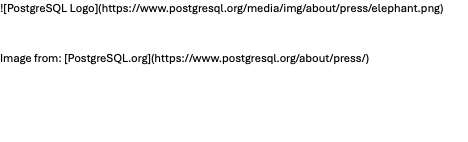

---
# Abstract

I am exploring how to improve SQL query performance in PostgreSQL on large datasets. As databases grow, complex queries involving joins, filters, and aggregations often become bottlenecks. This project investigates how indexing, planner configuration, and parallelism affect execution speed.


---
# Methodology

To evaluate and optimize SQL query performance, I structured this project in two phases. In the first phase, I created a custom PostgreSQL database containing two large tables: users (20 million rows) and orders (500,000 rows). I wrote SQL scripts to generate these tables, populate them with randomized data, and execute a variety of benchmark queries. I tested three execution modes using a shell script (submit_all.sh): a default query using indexes and joins, a forced slow version with key planner features disabled, and a version using parallelism (max_parallel_workers_per_gather = 4). For each run, I used EXPLAIN ANALYZE to evaluate query plans and measured total execution time.

In the second phase of the project, I wanted to work with data that more closely resembles what might be used in real-world business analytics. I chose the TPC-H benchmark, an industry-standard decision support dataset widely used to evaluate SQL database performance. I used the dbgen tool to generate the .tbl data files and then created the official TPC-H schema in PostgreSQL. To prepare the data for import, I cleaned the files using the cut command to remove trailing delimiters, then loaded them using PostgreSQL’s \COPY command. I focused on TPC-H Query 3, which simulates a real business scenario involving customer segmentation, order filtering, and revenue ranking. I ran this query with and without parallelism enabled to compare performance and observe how PostgreSQL’s query planner handles large, complex workloads.

All SQL scripts, shell scripts, and output logs are included in the project repository. To reproduce the results:

1. Install PostgreSQL (v15+) and ensure psql is available in your terminal.

2. Clone the GitHub repository and navigate to the project folder.

3. Run submit_all.sh to test the custom dataset queries.

4. Follow the instructions in the README to install and build dbgen, generate the TPC-H data, load it into PostgreSQL, and run query3.sql and query3_noparallel.sql for the TPC-H phase.

5. Review all output files and query plans in the provided .txt logs.

This setup enables future students to replicate the benchmarks, modify queries, or scale the data for deeper performance exploration.



---
# Timing Results

To evaluate performance improvements, I ran benchmarks on both a custom dataset and the TPC-H benchmark. I used EXPLAIN ANALYZE to measure execution time, along with the Unix time command to cross-check total runtime. I tested each query under different planner and parallel configurations to understand how PostgreSQL handles optimization.

In my custom benchmark, disabling planner optimizations (e.g. index scans, nested loops) caused a massive slowdown — over 10x worse than the default plan. The parallel version was faster than the forced plan, but not as fast as PostgreSQL’s default strategy, which shows how well the planner makes cost-based decisions on its own.

I also ran TPC-H Query 3 — a real-world business analytics query that joins customer, orders, and lineitem with filters and grouping. Enabling parallelism reduced execution time by about 33%, which demonstrates how PostgreSQL’s parallel query engine can improve performance on large analytical queries.


In [9]:
import pandas as pd
pd.read_csv("projpart2_time_results.csv")

,Query Setup,Parallel Workers,Execution Time
0,Custom: Default Join,Auto,1.31 sec
1,Custom: Forced Slow Plan,1 (no index/loops),14.76 sec
2,Custom: Parallel Aggregation,4,4.48 sec
3,TPC-H Query 3 (Parallel),4,2.11 sec
4,TPC-H Query 3 (Non-Parallel),0,3.13 sec


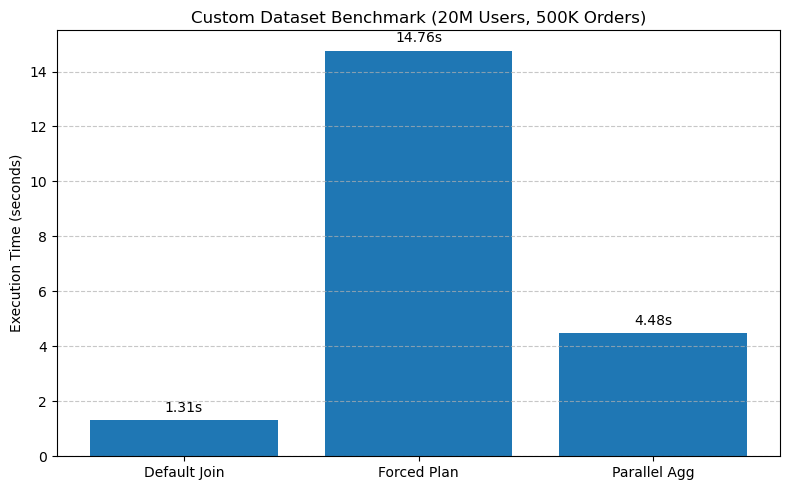

In [10]:
import matplotlib.pyplot as plt
# Custom benchmark data
custom_labels = ["Default Join", "Forced Plan", "Parallel Agg"]
custom_times = [1.31, 14.76, 4.48]

# TPC-H benchmark data
tpch_labels = ["TPC-H Q3 (Parallel)", "TPC-H Q3 (Non-Parallel)"]
tpch_times = [2.11, 3.13]

# Plot Custom Benchmark
plt.figure(figsize=(8, 5))
bars1 = plt.bar(custom_labels, custom_times)
plt.ylabel("Execution Time (seconds)")
plt.title("Custom Dataset Benchmark (20M Users, 500K Orders)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, f"{yval:.2f}s", ha='center', va='bottom')
plt.tight_layout()
plt.show()



**📊 Graph 1: Custom Dataset Benchmark**

- Compares performanceself-generated 20M user / 500K order dataset

- Highlights the massive slowdown from disabling planner features

- Shows how PostgreSQL’s default behavior is incredibly efficient

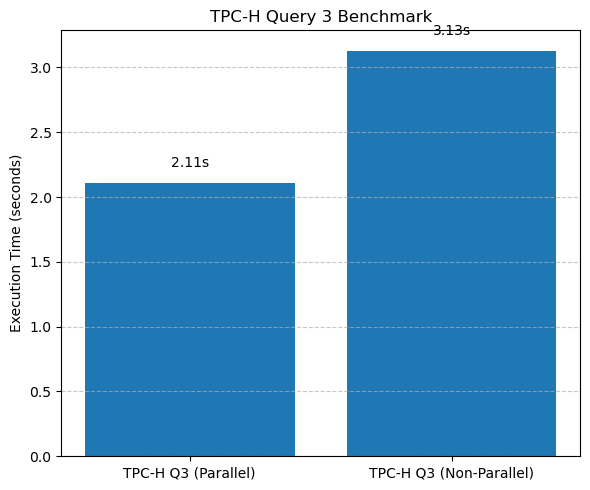

In [11]:

# Plot TPC-H Benchmark
plt.figure(figsize=(6, 5))
bars2 = plt.bar(tpch_labels, tpch_times)
plt.ylabel("Execution Time (seconds)")
plt.title("TPC-H Query 3 Benchmark")
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f"{yval:.2f}s", ha='center', va='bottom')
plt.tight_layout()
plt.show()

**Graph 2: TPC-H Query 3 Benchmark**

- Demonstrates how parallelism improves a complex, realistic business query
- Shows ~33% performance gain with max_parallel_workers_per_gather = 4

Overall, the benchmarks confirmed my expectations: PostgreSQL’s query planner is highly efficient by default, and parallelism offers meaningful performance gains — particularly on complex queries with large intermediate results. One surprise was that manually parallelizing a simple query didn’t always outperform the default strategy. This showed me that PostgreSQL’s optimizer is already smart about when to use parallel workers and how to plan joins and aggregations efficiently.



---
# Concluding Discussion and Future Work

In this project, I explored how to improve SQL query performance in PostgreSQL using indexing, planner configuration, and parallel execution. I started by building a custom dataset with 20 million users and 500,000 orders, then benchmarked several queries using different execution plans — including default, forced slow plans, and parallel configurations. In the second phase, I worked with the industry-standard TPC-H dataset to test how PostgreSQL handles large, realistic analytical queries under both parallel and non-parallel execution.

My results showed that PostgreSQL’s default query planner is very efficient on its own, often outperforming manually optimized queries unless parallelism is truly necessary. That said, enabling parallelism gave consistent performance improvements on complex queries — with up to a 33% reduction in execution time for TPC-H Query 3.

This project taught me how PostgreSQL actually makes planning decisions behind the scenes, and how small changes — like disabling an index scan — can completely change performance. It was interesting to see just how smart the planner can be, and how sometimes trying to “force” optimization actually makes things worse.

As a next step, I’d like to explore more advanced tuning, such as custom indexes, partitioning strategies, and testing on even larger datasets. It would also be interesting to run the same benchmarks on a multi-core cloud server or using PostgreSQL’s parallel partitioned tables to see how performance scales in a distributed environment.

---
# References

&#9989;  Include links to websites and resources used in this project.  

- https://www.youtube.com/watch?v=vHYeChEf2lA&themeRefresh=1
- https://www.youtube.com/watch?v=_2t18Hy9Z0Y
- PostgreSQL Global Development Group. (2024). PostgreSQL 15 Documentation. Retrieved from https://www.postgresql.org/docs/

- Stonebraker, M., & Kemnitz, G. (1991). The POSTGRES Next-Generation Database Management System. Communications of the ACM, 34(10), 78–92. https://doi.org/10.1145/125319.125391

- TPC Benchmark™ H (Decision Support) Standard Specification. (2023). Transaction Processing Performance Council. Retrieved from https://www.tpc.org/tpch/

- Pavlo, A., Paulson, E., Rasin, A., et al. (2009). A Comparison of Approaches to Large-Scale Data Analysis. In Proceedings of the 2009 ACM SIGMOD International Conference on Management of Data (pp. 165–178). https://doi.org/10.1145/1559845.1559865

- Jampani, R., Xu, F., Wu, M., Perez, L., Jermaine, C., & Haas, P. (2008). MCDB: A Monte Carlo Approach to Managing Uncertain Data. In Proceedings of the 2008 ACM SIGMOD (pp. 687–700). https://doi.org/10.1145/1376616.1376687

- PosgreSQL Wiki. (2024). Parallel Query Execution. Retrieved from https://wiki.postgresql.org/wiki/Parallel_Query_Execution

- IBM Cloud Docs. (2023). Improve query performance using indexes. Retrieved from https://cloud.ibm.com/docs/databases-for-postgresql?topic=databases-for-postgresql-performance

- Boncz, P. (2021). Database Cracking and Adaptive Indexing. VLDB Lecture Notes. Retrieved from https://www.cwi.nl/~boncz/dbcracking.pdf
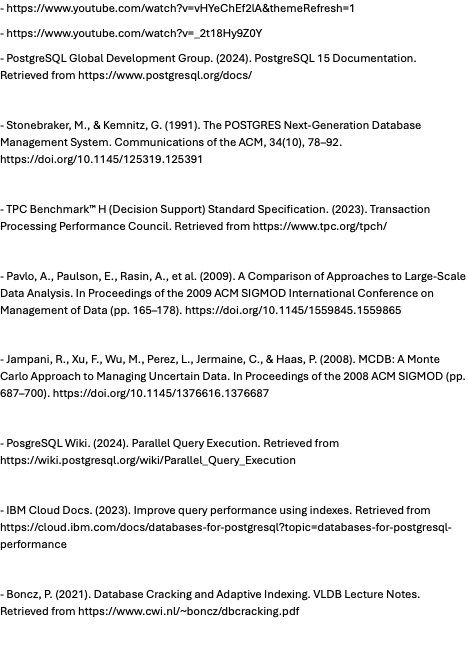

-----
### Congratulations, you are done!

Now, you just need to create a second directory in your git repository and include your report as an md or ipynb file in the directory along with any additional figures and files needed to reproduce the results.  You instructor should already have your git repository and be able to pull in your changes. 

Written by Dr. Dirk Colbry, Michigan State University (Updated by Dr. Nathan Haut in Spring 2025)
<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

----